/var/folders/dw/nbws69bn1czd2gbykbfjmnmc0000gn/T/ipykernel_9259/3032468987.py:148: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[b, oc, i, j] = np.sum(window * self.W[oc]) + self.b[oc]


Epoch  1 | Train Loss: 0.6296, Train Acc: 0.8200 | Val Loss: 0.6305, Val Acc: 0.7800
Epoch 10 | Train Loss: 0.0715, Train Acc: 1.0000 | Val Loss: 0.0724, Val Acc: 1.0000
Epoch 20 | Train Loss: 0.0051, Train Acc: 1.0000 | Val Loss: 0.0052, Val Acc: 1.0000
Epoch 30 | Train Loss: 0.0015, Train Acc: 1.0000 | Val Loss: 0.0015, Val Acc: 1.0000
Epoch 40 | Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0007, Val Acc: 1.0000
Epoch 50 | Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0003, Val Acc: 1.0000


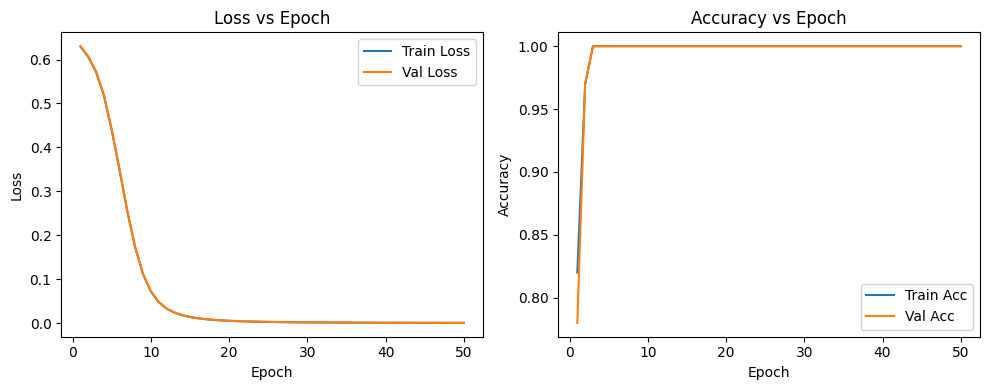


Final Metrics: Train Acc: 1.0000, Val Acc: 1.0000


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) Synthetic 8×8 Dataset Generator
# ----------------------------------------
def generate_tiny_dataset(n_per_class=500, seed=0):
    """
    Creates a dataset of 8×8 grayscale images with two classes:
      - Class 0: 3×3 white square in top‐left corner
      - Class 1: 3×3 white square in bottom‐right corner
    Returns:
      X: shape (2*n_per_class, 1, 8, 8)  — 1 channel, 8×8 images
      Y: one‐hot labels shape (2*n_per_class, 2)
    """
    np.random.seed(seed)
    total = 2 * n_per_class
    X = np.zeros((total, 1, 8, 8), dtype=np.float32)
    Y = np.zeros((total, 2), dtype=np.float32)

    for i in range(n_per_class):
        # Class 0
        img0 = np.zeros((8, 8), dtype=np.float32)
        img0[0:3, 0:3] = 1.0  # white square top-left
        # Add a tiny bit of noise
        img0 += 0.1 * np.random.randn(8, 8).astype(np.float32)
        X[i, 0] = img0
        Y[i, 0] = 1.0

        # Class 1
        img1 = np.zeros((8, 8), dtype=np.float32)
        img1[5:8, 5:8] = 1.0  # white square bottom-right
        img1 += 0.1 * np.random.randn(8, 8).astype(np.float32)
        X[n_per_class + i, 0] = img1
        Y[n_per_class + i, 1] = 1.0

    # Shuffle
    perm = np.random.permutation(total)
    return X[perm], Y[perm]


# ----------------------------------------
# 2) Utility Functions
# ----------------------------------------
def xavier_init(shape):
    """
    Xavier (Glorot) uniform initialization:
      shape = (fan_in, fan_out) or for conv: (out_ch, in_ch, k, k)
    """
    if len(shape) == 2:
        fan_in, fan_out = shape
    else:
        # For conv: shape = (out_channels, in_channels, k, k)
        out_ch, in_ch, k, _ = shape
        fan_in = in_ch * k * k
        fan_out = out_ch * k * k
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=shape)


def relu(z):
    return np.maximum(0, z)


def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ


def softmax(z):
    """
    z: shape (batch, num_classes)
    returns: (batch, num_classes)
    """
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


def cross_entropy_loss(probs, Y_true, eps=1e-12):
    """
    probs: shape (batch, num_classes), output of softmax
    Y_true: one-hot labels, same shape
    returns: (loss, dL/dz) where z are logits
    """
    m = Y_true.shape[0]
    clipped = np.clip(probs, eps, 1 - eps)
    loss = -np.sum(Y_true * np.log(clipped)) / m
    dL_dz = (probs - Y_true) / m  # derivative of softmax+CE combined
    return loss, dL_dz


# ----------------------------------------
# 3) Convolutional Layer (Conv2D)
# ----------------------------------------
class Conv2D:
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        """
        in_ch: number of input channels
        out_ch: number of output channels (filters)
        kernel_size: assume square kernel (k × k)
        stride: stride for convolution
        padding: number of zero‐padding pixels on each side
        """
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.k = kernel_size
        self.stride = stride
        self.pad = padding

        # Weight shape: (out_ch, in_ch, k, k)
        self.W = xavier_init((out_ch, in_ch, kernel_size, kernel_size))
        self.b = np.zeros((out_ch, 1), dtype=np.float32)

        # Placeholders for gradient and cache
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        self.cache = None

    def forward(self, X):
        """
        X: shape (batch, in_ch, H, W)
        returns: Z of shape (batch, out_ch, H_out, W_out)
        where H_out = (H + 2*pad - k)//stride + 1
        """
        batch, _, H, W = X.shape
        k, s, p = self.k, self.stride, self.pad

        # Output spatial dims
        H_out = (H + 2 * p - k) // s + 1
        W_out = (W + 2 * p - k) // s + 1

        # Pad input
        X_pad = np.pad(X, ((0, 0), (0, 0), (p, p), (p, p)), mode="constant")

        # Initialize output
        Z = np.zeros((batch, self.out_ch, H_out, W_out), dtype=np.float32)

        # Convolution
        for b in range(batch):
            for oc in range(self.out_ch):
                for i in range(H_out):
                    for j in range(W_out):
                        i0 = i * s
                        j0 = j * s
                        window = X_pad[b, :, i0 : i0 + k, j0 : j0 + k]  # shape (in_ch, k, k)
                        Z[b, oc, i, j] = np.sum(window * self.W[oc]) + self.b[oc]

        # Cache for backward
        self.cache = (X, X_pad)
        return Z

    def backward(self, dZ):
        """
        dZ: upstream gradient of shape (batch, out_ch, H_out, W_out)
        computes: self.dW, self.db, returns dX of shape (batch, in_ch, H, W)
        """
        X, X_pad = self.cache
        batch, _, H, W = X.shape
        p, s, k = self.pad, self.stride, self.k

        # Output spatial dims
        H_out = dZ.shape[2]
        W_out = dZ.shape[3]

        # Initialize gradients
        dX_pad = np.zeros_like(X_pad)
        self.dW.fill(0)
        self.db.fill(0)

        # Compute gradients
        for b in range(batch):
            for oc in range(self.out_ch):
                for i in range(H_out):
                    for j in range(W_out):
                        i0 = i * s
                        j0 = j * s
                        window = X_pad[b, :, i0 : i0 + k, j0 : j0 + k]
                        self.dW[oc] += dZ[b, oc, i, j] * window
                        self.db[oc] += dZ[b, oc, i, j]
                        dX_pad[b, :, i0 : i0 + k, j0 : j0 + k] += dZ[b, oc, i, j] * self.W[oc]

        # Remove padding
        if p > 0:
            dX = dX_pad[:, :, p : -p, p : -p]
        else:
            dX = dX_pad

        return dX


# ----------------------------------------
# 4) MaxPooling Layer (2×2, stride 2)
# ----------------------------------------
class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool = pool_size
        self.stride = stride
        self.cache = None

    def forward(self, X):
        """
        X: shape (batch, channels, H, W)
        returns: Pooled output of shape
                 (batch, channels, H_out, W_out)
        where H_out = H//pool, W_out = W//pool (assuming divisible)
        """
        batch, ch, H, W = X.shape
        p, s = self.pool, self.stride
        H_out = H // p
        W_out = W // p

        P = np.zeros((batch, ch, H_out, W_out), dtype=np.float32)
        mask = np.zeros_like(X, dtype=np.float32)

        for b in range(batch):
            for c in range(ch):
                for i in range(H_out):
                    for j in range(W_out):
                        i0 = i * s
                        j0 = j * s
                        window = X[b, c, i0 : i0 + p, j0 : j0 + p]
                        m = np.max(window)
                        P[b, c, i, j] = m
                        # record mask for backprop
                        mask_window = (window == m)
                        mask[b, c, i0 : i0 + p, j0 : j0 + p] = mask_window

        self.cache = mask
        return P

    def backward(self, dP):
        """
        dP: gradient shape (batch, ch, H_out, W_out)
        returns: dX (same shape as input X)
        """
        mask = self.cache
        batch, ch, H_out, W_out = dP.shape
        dX = np.zeros_like(mask, dtype=np.float32)
        p, s = self.pool, self.stride

        for b in range(batch):
            for c in range(ch):
                for i in range(H_out):
                    for j in range(W_out):
                        i0 = i * s
                        j0 = j * s
                        dX[b, c, i0 : i0 + p, j0 : j0 + p] += (
                            mask[b, c, i0 : i0 + p, j0 : j0 + p] * dP[b, c, i, j]
                        )
        return dX


# ----------------------------------------
# 5) Flatten Layer
# ----------------------------------------
class Flatten:
    def __init__(self):
        self.input_shape = None

    def forward(self, X):
        """
        X: shape (batch, ch, H, W)
        returns: X_flat of shape (batch, ch*H*W)
        """
        self.input_shape = X.shape
        return X.reshape(X.shape[0], -1)

    def backward(self, dX_flat):
        """
        dX_flat: shape (batch, ch*H*W)
        returns: dX of shape (batch, ch, H, W)
        """
        return dX_flat.reshape(self.input_shape)


# ----------------------------------------
# 6) Fully-Connected Layer (Dense)
# ----------------------------------------
class Dense:
    def __init__(self, in_dim, out_dim):
        """
        in_dim: input features
        out_dim: output features
        """
        self.W = xavier_init((in_dim, out_dim))
        self.b = np.zeros((1, out_dim), dtype=np.float32)

        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        self.cache = None

    def forward(self, X):
        """
        X: shape (batch, in_dim)
        returns: Z shape (batch, out_dim)
        """
        self.cache = X
        return X.dot(self.W) + self.b

    def backward(self, dZ):
        """
        dZ: shape (batch, out_dim)
        returns: dX shape (batch, in_dim)
        """
        X = self.cache
        m = X.shape[0]
        self.dW = X.T.dot(dZ)
        self.db = np.sum(dZ, axis=0, keepdims=True)
        dX = dZ.dot(self.W.T)
        return dX


# ----------------------------------------
# 7) Adam Optimizer with L2 Weight Decay
# ----------------------------------------
class AdamOptimizer:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=1e-4):
        """
        params: dict of parameter_name → NumPy array
        """
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = {k: np.zeros_like(v) for k, v in params.items()}
        self.v = {k: np.zeros_like(v) for k, v in params.items()}
        self.t = 0

    def step(self, grads):
        """
        grads: dict of parameter_name → gradient array
        """
        self.t += 1
        lr_t = self.lr * np.sqrt(1 - self.beta2**self.t) / (1 - self.beta1**self.t)
        for k in self.params:
            grad = grads[k].copy()
            if k.startswith("W"):
                grad += self.weight_decay * self.params[k]
            self.m[k] = self.beta1 * self.m[k] + (1 - self.beta1) * grad
            self.v[k] = self.beta2 * self.v[k] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[k] / (1 - self.beta1**self.t)
            v_hat = self.v[k] / (1 - self.beta2**self.t)
            self.params[k] -= lr_t * m_hat / (np.sqrt(v_hat) + self.eps)


# ----------------------------------------
# 8) CNN Model Combining Everything
# ----------------------------------------
class SimpleCNN:
    def __init__(self):
        # Conv layer: 1 → 2 channels, kernel 3×3, stride 1, padding 1
        self.conv = Conv2D(in_ch=1, out_ch=2, kernel_size=3, stride=1, padding=1)
        self.relu1 = None  # will use relu in forward/back

        # MaxPool 2×2, stride 2
        self.pool = MaxPool2D(pool_size=2, stride=2)

        # Flatten
        self.flat = Flatten()

        # Fully connected: (2 × 4 × 4) → 16
        self.fc1 = Dense(in_dim=2 * 4 * 4, out_dim=16)
        # ReLU after fc1
        # Output layer: 16 → 2
        self.fc2 = Dense(in_dim=16, out_dim=2)

        # Collect all trainable parameters in a dict
        self.params = {
            "W_conv": self.conv.W,
            "b_conv": self.conv.b,
            "W_fc1": self.fc1.W,
            "b_fc1": self.fc1.b,
            "W_fc2": self.fc2.W,
            "b_fc2": self.fc2.b,
        }

    def forward(self, X, training=True):
        """
        X: shape (batch, 1, 8, 8)
        returns: probabilities shape (batch, 2)
        caches all intermediate values for backward
        """
        # 1) Conv → ReLU
        Z_conv = self.conv.forward(X)                       # (batch, 2, 8, 8)
        A_conv = relu(Z_conv)                               # (batch, 2, 8, 8)

        # 2) MaxPool → shapes (batch, 2, 4, 4)
        P = self.pool.forward(A_conv)                       # (batch, 2, 4, 4)

        # 3) Flatten → (batch, 2*4*4)
        F = self.flat.forward(P)                            # (batch, 32)

        # 4) FC1 → ReLU
        Z1 = self.fc1.forward(F)                            # (batch, 16)
        A1 = relu(Z1)                                       # (batch, 16)

        # 5) FC2 → logits (batch, 2)
        Z2 = self.fc2.forward(A1)                           # (batch, 2)

        # 6) Softmax
        probs = softmax(Z2)                                 # (batch, 2)

        # Cache everything
        self.cache = {
            "X": X,
            "Z_conv": Z_conv, "A_conv": A_conv,
            "P": P,
            "F": F,
            "Z1": Z1, "A1": A1,
            "Z2": Z2,
            "probs": probs,
        }
        return probs

    def backward(self, Y_true):
        """
        Y_true: one-hot labels (batch, 2)
        returns: loss, dict of gradients matching self.params keys
        """
        # Retrieve from cache
        X = self.cache["X"]
        Z_conv = self.cache["Z_conv"]
        A_conv = self.cache["A_conv"]
        P = self.cache["P"]
        F = self.cache["F"]
        Z1 = self.cache["Z1"]
        A1 = self.cache["A1"]
        Z2 = self.cache["Z2"]
        probs = self.cache["probs"]

        grads = {}

        # 1) Loss + dL/dZ2
        loss, dZ2 = cross_entropy_loss(probs, Y_true)       # (batch, 2)

        # 2) Backprop through fc2
        grads["W_fc2"] = A1.T.dot(dZ2)                       # (16, 2)
        grads["b_fc2"] = np.sum(dZ2, axis=0, keepdims=True)  # (1, 2)
        dA1 = dZ2.dot(self.fc2.W.T)                          # (batch, 16)

        # 3) Backprop through ReLU1
        dZ1 = relu_backward(dA1, Z1)                         # (batch, 16)

        # 4) Backprop through fc1
        grads["W_fc1"] = F.T.dot(dZ1)                        # (32, 16)
        grads["b_fc1"] = np.sum(dZ1, axis=0, keepdims=True)  # (1, 16)
        dF = dZ1.dot(self.fc1.W.T)                           # (batch, 32)

        # 5) Backprop through Flatten
        dP = self.flat.backward(dF)                          # (batch, 2, 4, 4)

        # 6) Backprop through MaxPool
        dA_conv = self.pool.backward(dP)                     # (batch, 2, 8, 8)

        # 7) Backprop through ReLU on conv output
        dZ_conv = relu_backward(dA_conv, Z_conv)             # (batch, 2, 8, 8)

        # 8) Backprop through conv
        dX = self.conv.backward(dZ_conv)                     # (batch, 1, 8, 8)

        grades_conv_W = self.conv.dW                          # shape (2,1,3,3)
        grades_conv_b = self.conv.db                          # shape (2,1)

        # Package all grads
        grads["W_conv"] = grades_conv_W
        grads["b_conv"] = grades_conv_b

        return loss, grads

    def accuracy(self, X, Y_true):
        """
        Compute accuracy: fraction correct on (X, Y_true)
        """
        probs = self.forward(X, training=False)
        preds = np.argmax(probs, axis=1)
        labels = np.argmax(Y_true, axis=1)
        return np.mean(preds == labels)


# ----------------------------------------
# 9) Training Loop for SimpleCNN
# ----------------------------------------
def train_cnn():
    # Hyperparameters
    epochs = 50
    batch_size = 32
    learning_rate = 0.001
    weight_decay = 1e-4

    # Generate data
    X, Y = generate_tiny_dataset(n_per_class=500, seed=42)
    total = X.shape[0]
    split = int(0.8 * total)
    X_train, Y_train = X[:split], Y[:split]
    X_val,   Y_val   = X[split:], Y[split:]

    # Instantiate model & optimizer
    model = SimpleCNN()
    optimizer = AdamOptimizer(model.params, lr=learning_rate, weight_decay=weight_decay)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        # Shuffle training set at each epoch
        perm = np.random.permutation(X_train.shape[0])
        X_train, Y_train = X_train[perm], Y_train[perm]

        # Mini-batch training
        for i in range(0, X_train.shape[0], batch_size):
            xb = X_train[i : i + batch_size]
            yb = Y_train[i : i + batch_size]

            _ = model.forward(xb, training=True)
            loss, grads = model.backward(yb)

            # Align grads dict keys with params
            grad_dict = {
                "W_conv": grads["W_conv"],
                "b_conv": grads["b_conv"],
                "W_fc1": grads["W_fc1"],
                "b_fc1": grads["b_fc1"],
                "W_fc2": grads["W_fc2"],
                "b_fc2": grads["b_fc2"],
            }
            optimizer.step(grad_dict)

        # End of epoch: compute train & val metrics
        train_probs = model.forward(X_train, training=False)
        train_loss, _ = cross_entropy_loss(train_probs, Y_train)
        train_acc = model.accuracy(X_train, Y_train)

        val_probs = model.forward(X_val, training=False)
        val_loss, _ = cross_entropy_loss(val_probs, Y_val)
        val_acc = model.accuracy(X_val, Y_val)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:2d} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    # Plot loss & accuracy
    es = np.arange(1, epochs + 1)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(es, history["train_loss"], label="Train Loss")
    plt.plot(es, history["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(), plt.title("Loss vs Epoch")

    plt.subplot(1, 2, 2)
    plt.plot(es, history["train_acc"], label="Train Acc")
    plt.plot(es, history["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(), plt.title("Accuracy vs Epoch")

    plt.tight_layout()
    plt.show()

    print(
        "\nFinal Metrics: "
        f"Train Acc: {history['train_acc'][-1]:.4f}, "
        f"Val Acc: {history['val_acc'][-1]:.4f}"
    )


if __name__ == "__main__":
    train_cnn()